# Importing Libraries and Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import scipy.stats as stats
from sklearn import linear_model, feature_selection, metrics, model_selection, impute, datasets
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

counties_pol_party = pd.read_csv('counties_pol.csv')

In [3]:
counties_pol_party.shape
counties_pol_party.reset_index(inplace=True)
counties_pol_party = counties_pol_party.drop(columns='index')

In [5]:
# changing fips to str value
counties_pol_party['fips']= counties_pol_party['fips'].astype(str)

## Standardizing Values

In [6]:
independent_vars = ['income_inequality', 'gender_pay_gap',
       'school_segration_index', 'residential_segregation',
       'school_funding_gap']

dependent_vars = ['hs_diploma_percentage', 'unemployed_percentage', 'population', 'median_income', 'uninsured__percentage', 'premature_death', 'child_poverty_percentage', 'life_expectancy', 'child_mortality', 'high_housing_cost_percentage', 'firearm_fatalities', 'child_care_cost_burden']
vars_to_z = independent_vars + dependent_vars
counties_pol_copy = counties_pol_party.copy()

In [7]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_z(df, cols):
    for i in df[cols]:
        df[i] = np.abs(stats.zscore(df[i])) 
    return df

In [8]:
z_counties= calc_z(counties_pol_copy, vars_to_z)

# Variable Selection with Pairwise Mutual Information 

In [9]:
# Initialize a matrix to store mutual information
mutual_info_matrix = np.zeros((len(independent_vars), len(dependent_vars)))

# Calculate mutual information for each independent-dependent variable pair
for i, var1 in enumerate(independent_vars):
    for j, var2 in enumerate(dependent_vars):
        X = counties_pol_party[[var1]]
        y = counties_pol_party[var2]
        mutual_info = mutual_info_regression(X, y)
        mutual_info_matrix[i, j] = mutual_info[0]  # Store the mutual info scalar

# Convert the matrix to a DataFrame for easier viewing
mutual_info_df = pd.DataFrame(mutual_info_matrix, index=independent_vars, columns=dependent_vars)

# Display the mutual information DataFrame
print(mutual_info_df)

                         hs_diploma_percentage  unemployed_percentage  \
income_inequality                     0.108655               0.073903   
gender_pay_gap                        0.044780               0.005237   
school_segration_index                0.022494               0.047669   
residential_segregation               0.044310               0.009836   
school_funding_gap                    0.223386               0.031179   

                         population  median_income  uninsured__percentage  \
income_inequality          0.026188       0.210516               0.072807   
gender_pay_gap             0.073671       0.026668               0.033544   
school_segration_index     0.180724       0.026264               0.011739   
residential_segregation    0.080845       0.021667               0.068701   
school_funding_gap         0.088500       0.249675               0.250499   

                         premature_death  child_poverty_percentage  \
income_inequality           

## Visualizing Pairwise Mutual Information as Heatmap

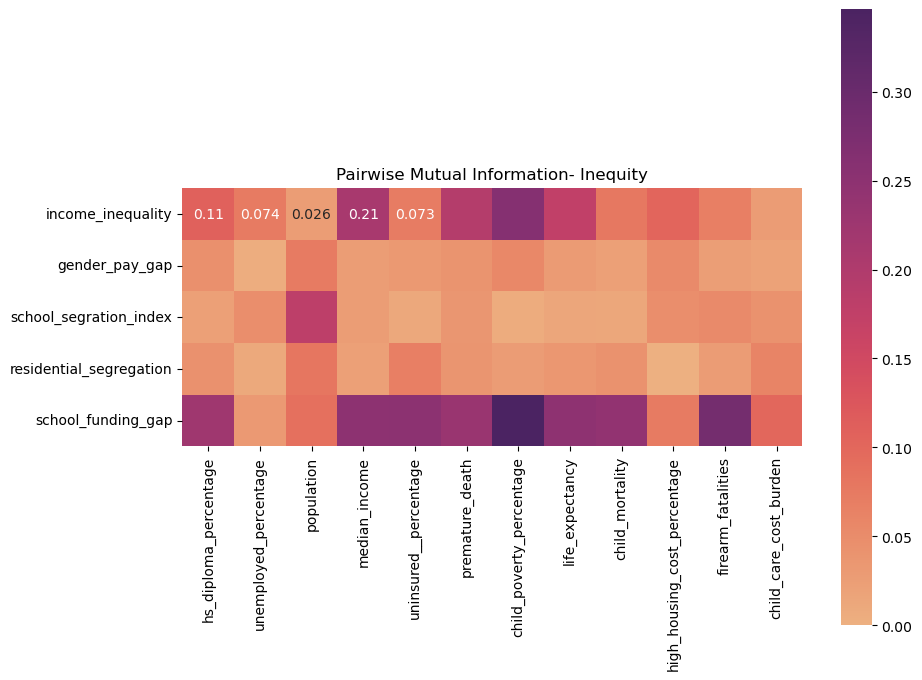

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(mutual_info_df, annot=True, cmap='flare', square=True)
plt.title('Pairwise Mutual Information- Inequity')
plt.show()

## Identifying most 'informative' pairs

In [11]:
top_var_pairs = mutual_info_df.unstack().sort_values(ascending=False).head(12)
print(top_var_pairs)

child_poverty_percentage  school_funding_gap        0.346409
firearm_fatalities        school_funding_gap        0.286253
child_poverty_percentage  income_inequality         0.262035
uninsured__percentage     school_funding_gap        0.250499
median_income             school_funding_gap        0.249675
life_expectancy           school_funding_gap        0.248667
child_mortality           school_funding_gap        0.242594
premature_death           school_funding_gap        0.232733
hs_diploma_percentage     school_funding_gap        0.223386
median_income             income_inequality         0.210516
premature_death           income_inequality         0.192150
population                school_segration_index    0.180724
dtype: float64


### Selecting most 'informative' variables
- x: 'school_funding_gap', 'income_inequality'
- y: 'child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'

*including political party elected from 2020 general election for additional comparative visualizations*

In [12]:
high_mutual_info_vars = ['state_abbr', 'county', 'fips', 'school_funding_gap', 'child_poverty_percentage', 'income_inequality', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death', 'political_party']
agg_select_subset = counties_pol_party[high_mutual_info_vars]
x_vars= ['school_funding_gap', 'income_inequality'],
y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death']

# Descriptive Statistics for Selected Variables

In [13]:
agg_select_subset.describe()

school_funding_gap  child_poverty_percentage  income_inequality  \
count         1648.000000               1648.000000        1648.000000   
mean          -804.972237                  0.188401           4.601347   
std           6428.722095                  0.076617           0.712400   
min         -46776.990000                  0.031000           2.882000   
25%          -3452.357750                  0.131000           4.100000   
50%           -309.820000                  0.181500           4.489000   
75%           2283.419000                  0.232000           4.976500   
max          21187.845000                  0.536000           8.278000   

       firearm_fatalities  median_income  life_expectancy  premature_death  
count         1648.000000    1648.000000      1648.000000      1648.000000  
mean            16.766254   67337.940534        74.852579     10482.455800  
std              7.598026   16490.494964         3.224961      3315.197567  
min              1.859000   34176.000000        63.845000      3990.294000  
25%             11.692500   55568.000000        72.604750      8089.242750  
50%             15.872000   64090.500000        74.880000     10155.796000  
75%             20.471750   75447.000000        77.070750     12482.990000  
max             79.459000  144807.000000        89.667000     27851.414000

## Variance 

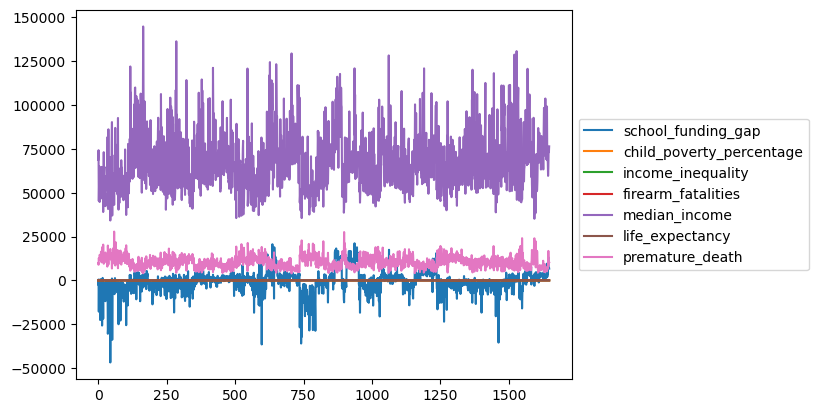

In [14]:
# Profile plot showing variance across variables
ax = agg_select_subset.plot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [15]:
agg_select_subset.var(numeric_only=True)

school_funding_gap          4.132847e+07
child_poverty_percentage    5.870140e-03
income_inequality           5.075141e-01
firearm_fatalities          5.772999e+01
median_income               2.719364e+08
life_expectancy             1.040037e+01
premature_death             1.099053e+07
dtype: float64

## Correlation 

<Axes: >

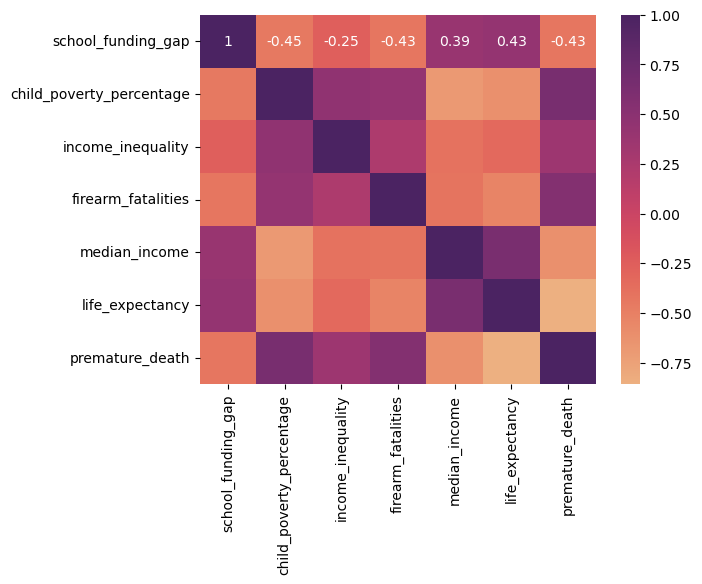

In [16]:
corr_matrix = agg_select_subset.corr(method='kendall', numeric_only=True).round(2)
sns.heatmap(corr_matrix, annot=True, cmap='flare')

### Correlation Pairs

In [17]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['school_funding_gap']))

child_poverty_percentage   -0.637112
firearm_fatalities         -0.604100
median_income               0.496392
life_expectancy             0.564720
premature_death            -0.579993
dtype: float64


In [18]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['income_inequality']))

child_poverty_percentage    0.622599
firearm_fatalities          0.366110
median_income              -0.503023
life_expectancy            -0.458570
premature_death             0.512731
dtype: float64


## Covariance

In [28]:
agg_select_subset.cov(numeric_only=True)

school_funding_gap  child_poverty_percentage  \
school_funding_gap              4.132847e+07               -313.808422   
child_poverty_percentage       -3.138084e+02                  0.005870   
income_inequality              -1.604994e+03                  0.033983   
firearm_fatalities             -2.950762e+04                  0.358648   
median_income                   5.262393e+07              -1025.676864   
life_expectancy                 1.170799e+04                 -0.194953   
premature_death                -1.236109e+07                206.086843   

                          income_inequality  firearm_fatalities  \
school_funding_gap             -1604.993605       -29507.623352   
child_poverty_percentage           0.033983            0.358648   
income_inequality                  0.507514            1.981693   
firearm_fatalities                 1.981693           57.729993   
median_income                  -5909.425788       -67516.434650   
life_expectancy                   -1.053547          -16.637639   
premature_death                 1210.940045        18173.464033   

                          median_income  life_expectancy  premature_death  
school_funding_gap         5.262393e+07     11707.985573    -1.236109e+07  
child_poverty_percentage  -1.025677e+03        -0.194953     2.060868e+02  
income_inequality         -5.909426e+03        -1.053547     1.210940e+03  
firearm_fatalities        -6.751643e+04       -16.637639     1.817346e+04  
median_income              2.719364e+08     41980.702934    -4.143769e+07  
life_expectancy            4.198070e+04        10.400371    -1.027420e+04  
premature_death           -4.143769e+07    -10274.195005     1.099053e+07

In [33]:
covar_matrix = agg_select_subset.cov(numeric_only=True)
print(covar_matrix)

                          school_funding_gap  child_poverty_percentage  \
school_funding_gap              4.132847e+07               -313.808422   
child_poverty_percentage       -3.138084e+02                  0.005870   
income_inequality              -1.604994e+03                  0.033983   
firearm_fatalities             -2.950762e+04                  0.358648   
median_income                   5.262393e+07              -1025.676864   
life_expectancy                 1.170799e+04                 -0.194953   
premature_death                -1.236109e+07                206.086843   

                          income_inequality  firearm_fatalities  \
school_funding_gap             -1604.993605       -29507.623352   
child_poverty_percentage           0.033983            0.358648   
income_inequality                  0.507514            1.981693   
firearm_fatalities                 1.981693           57.729993   
median_income                  -5909.425788       -67516.434650   
life_

## Pair Plots

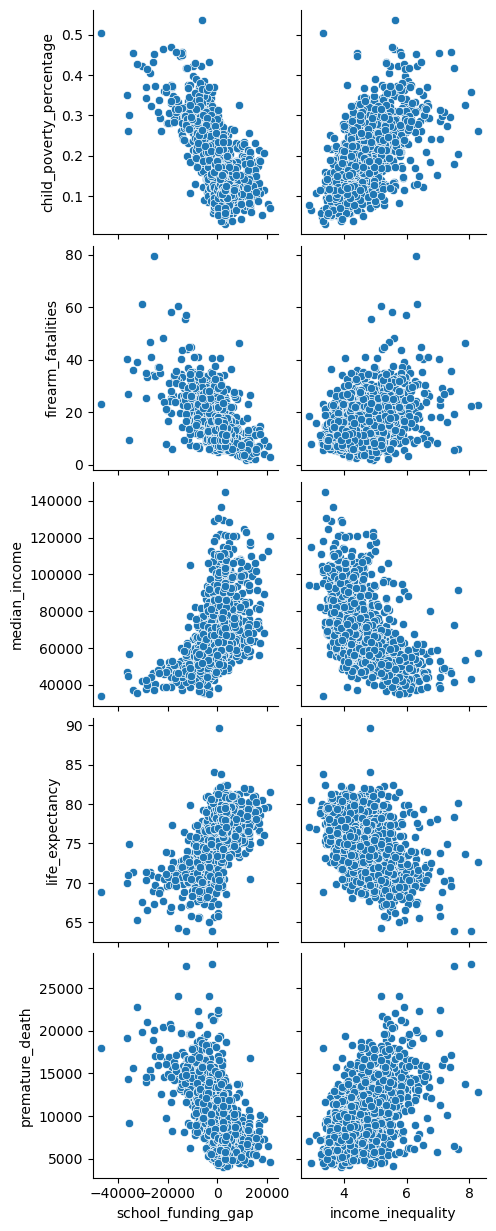

In [35]:
sns.pairplot(agg_select_subset, 
    x_vars= ['school_funding_gap', 'income_inequality'],
    y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'],
    )     

# Regression: Selecting Best Model 

## Multivariate

## Polynomial

## Model Evaluation

# Group Observations

## Defining Groups

In [20]:
grouped_df = agg_select_subset.copy()
# adding column with inequality quantile 
grouped_df['quartile_income_inequality'] = pd.qcut(grouped_df['income_inequality'], q=4, labels=False)
# adding column defining whether county meets federal school funding requirements
grouped_df['meeting_school_funding_requirement'] = np.where(grouped_df['school_funding_gap']>=0, 'yes', 'no')

### Descriptive Stats Accross Groups

In [23]:
school_funding_grouped = grouped_df.groupby('meeting_school_funding_requirement')
income_inequality_grouped = grouped_df.groupby('quartile_income_inequality')

In [24]:
school_funding_grouped.describe()

school_funding_gap               \
                                                count         mean   
meeting_school_funding_requirement                                   
no                                              875.0 -4815.788690   
yes                                             773.0  3735.085197   

                                                                               \
                                            std        min      25%       50%   
meeting_school_funding_requirement                                              
no                                  5483.206500 -46776.990 -6134.39 -3126.540   
yes                                 3906.568333      1.626  1182.52  2472.092   

                                                         \
                                         75%        max   
meeting_school_funding_requirement                        
no                                 -1410.700     -0.250   
yes                                 4430.501  21187.845   

                                   child_poverty_percentage            ...  \
                                                      count      mean  ...   
meeting_school_funding_requirement                                     ...   
no                                                    875.0  0.225733  ...   
yes                                                   773.0  0.146144  ...   

                                   premature_death             \
                                               75%        max   
meeting_school_funding_requirement                              
no                                       13711.183  27851.414   
yes                                      10292.251  22436.806   

                                   quartile_income_inequality            \
                                                        count      mean   
meeting_school_funding_requirement                                        
no                                                      875.0  1.802286   
yes                                                     773.0  1.152652   

                                                                       
                                         std  min  25%  50%  75%  max  
meeting_school_funding_requirement                                     
no                                  1.091257  0.0  1.0  2.0  3.0  3.0  
yes                                 1.050529  0.0  0.0  1.0  2.0  3.0  

[2 rows x 64 columns]

In [25]:
income_inequality_grouped.describe()

school_funding_gap                            \
                                        count         mean          std   
quartile_income_inequality                                                
0                                       415.0  1283.162935  4454.756956   
1                                       410.0   343.501680  5061.111084   
2                                       411.0  -253.227436  5797.628967   
3                                       412.0 -4601.616694  8132.181559   

                                                                       \
                                 min        25%       50%         75%   
quartile_income_inequality                                              
0                          -46776.99  -797.8980  1261.390  3061.95100   
1                          -33847.18 -2316.6135   134.710  2460.44300   
2                          -23516.77 -3365.7715  -524.422  2039.25450   
3                          -36495.30 -7886.4050 -3698.875    20.29725   

                                      child_poverty_percentage            ...  \
                                  max                    count      mean  ...   
quartile_income_inequality                                                ...   
0                           18231.331                    415.0  0.128706  ...   
1                           21187.845                    410.0  0.171966  ...   
2                           18898.087                    411.0  0.197720  ...   
3                           18897.735                    412.0  0.255590  ...   

                           life_expectancy         premature_death  \
                                       75%     max           count   
quartile_income_inequality                                           
0                                 78.54800  83.762           415.0   
1                                 76.99025  82.180           410.0   
2                                 76.38200  89.667           411.0   
3                                 74.49200  82.362           412.0   

                                                                             \
                                    mean          std       min         25%   
quartile_income_inequality                                                    
0                            8403.422188  2268.087094  3990.294   6864.0880   
1                            9797.678254  2386.135168  4276.043   8195.9550   
2                           10886.341107  2833.990933  4321.357   8889.1315   
3                           12855.176386  3813.639363  4157.993  10408.0895   

                                                                
                                   50%          75%        max  
quartile_income_inequality                                      
0                            8307.4600   9670.95200  19407.343  
1                            9699.5680  11381.37775  18377.170  
2                           10984.4910  12661.47000  18735.528  
3                           12912.6815  14843.18675  27851.414  

[4 rows x 56 columns]

## Overview: Grouped Pair Plots

### Across Schools Meeting Federal School Funding Requirements per pupil and those failing to meet them 

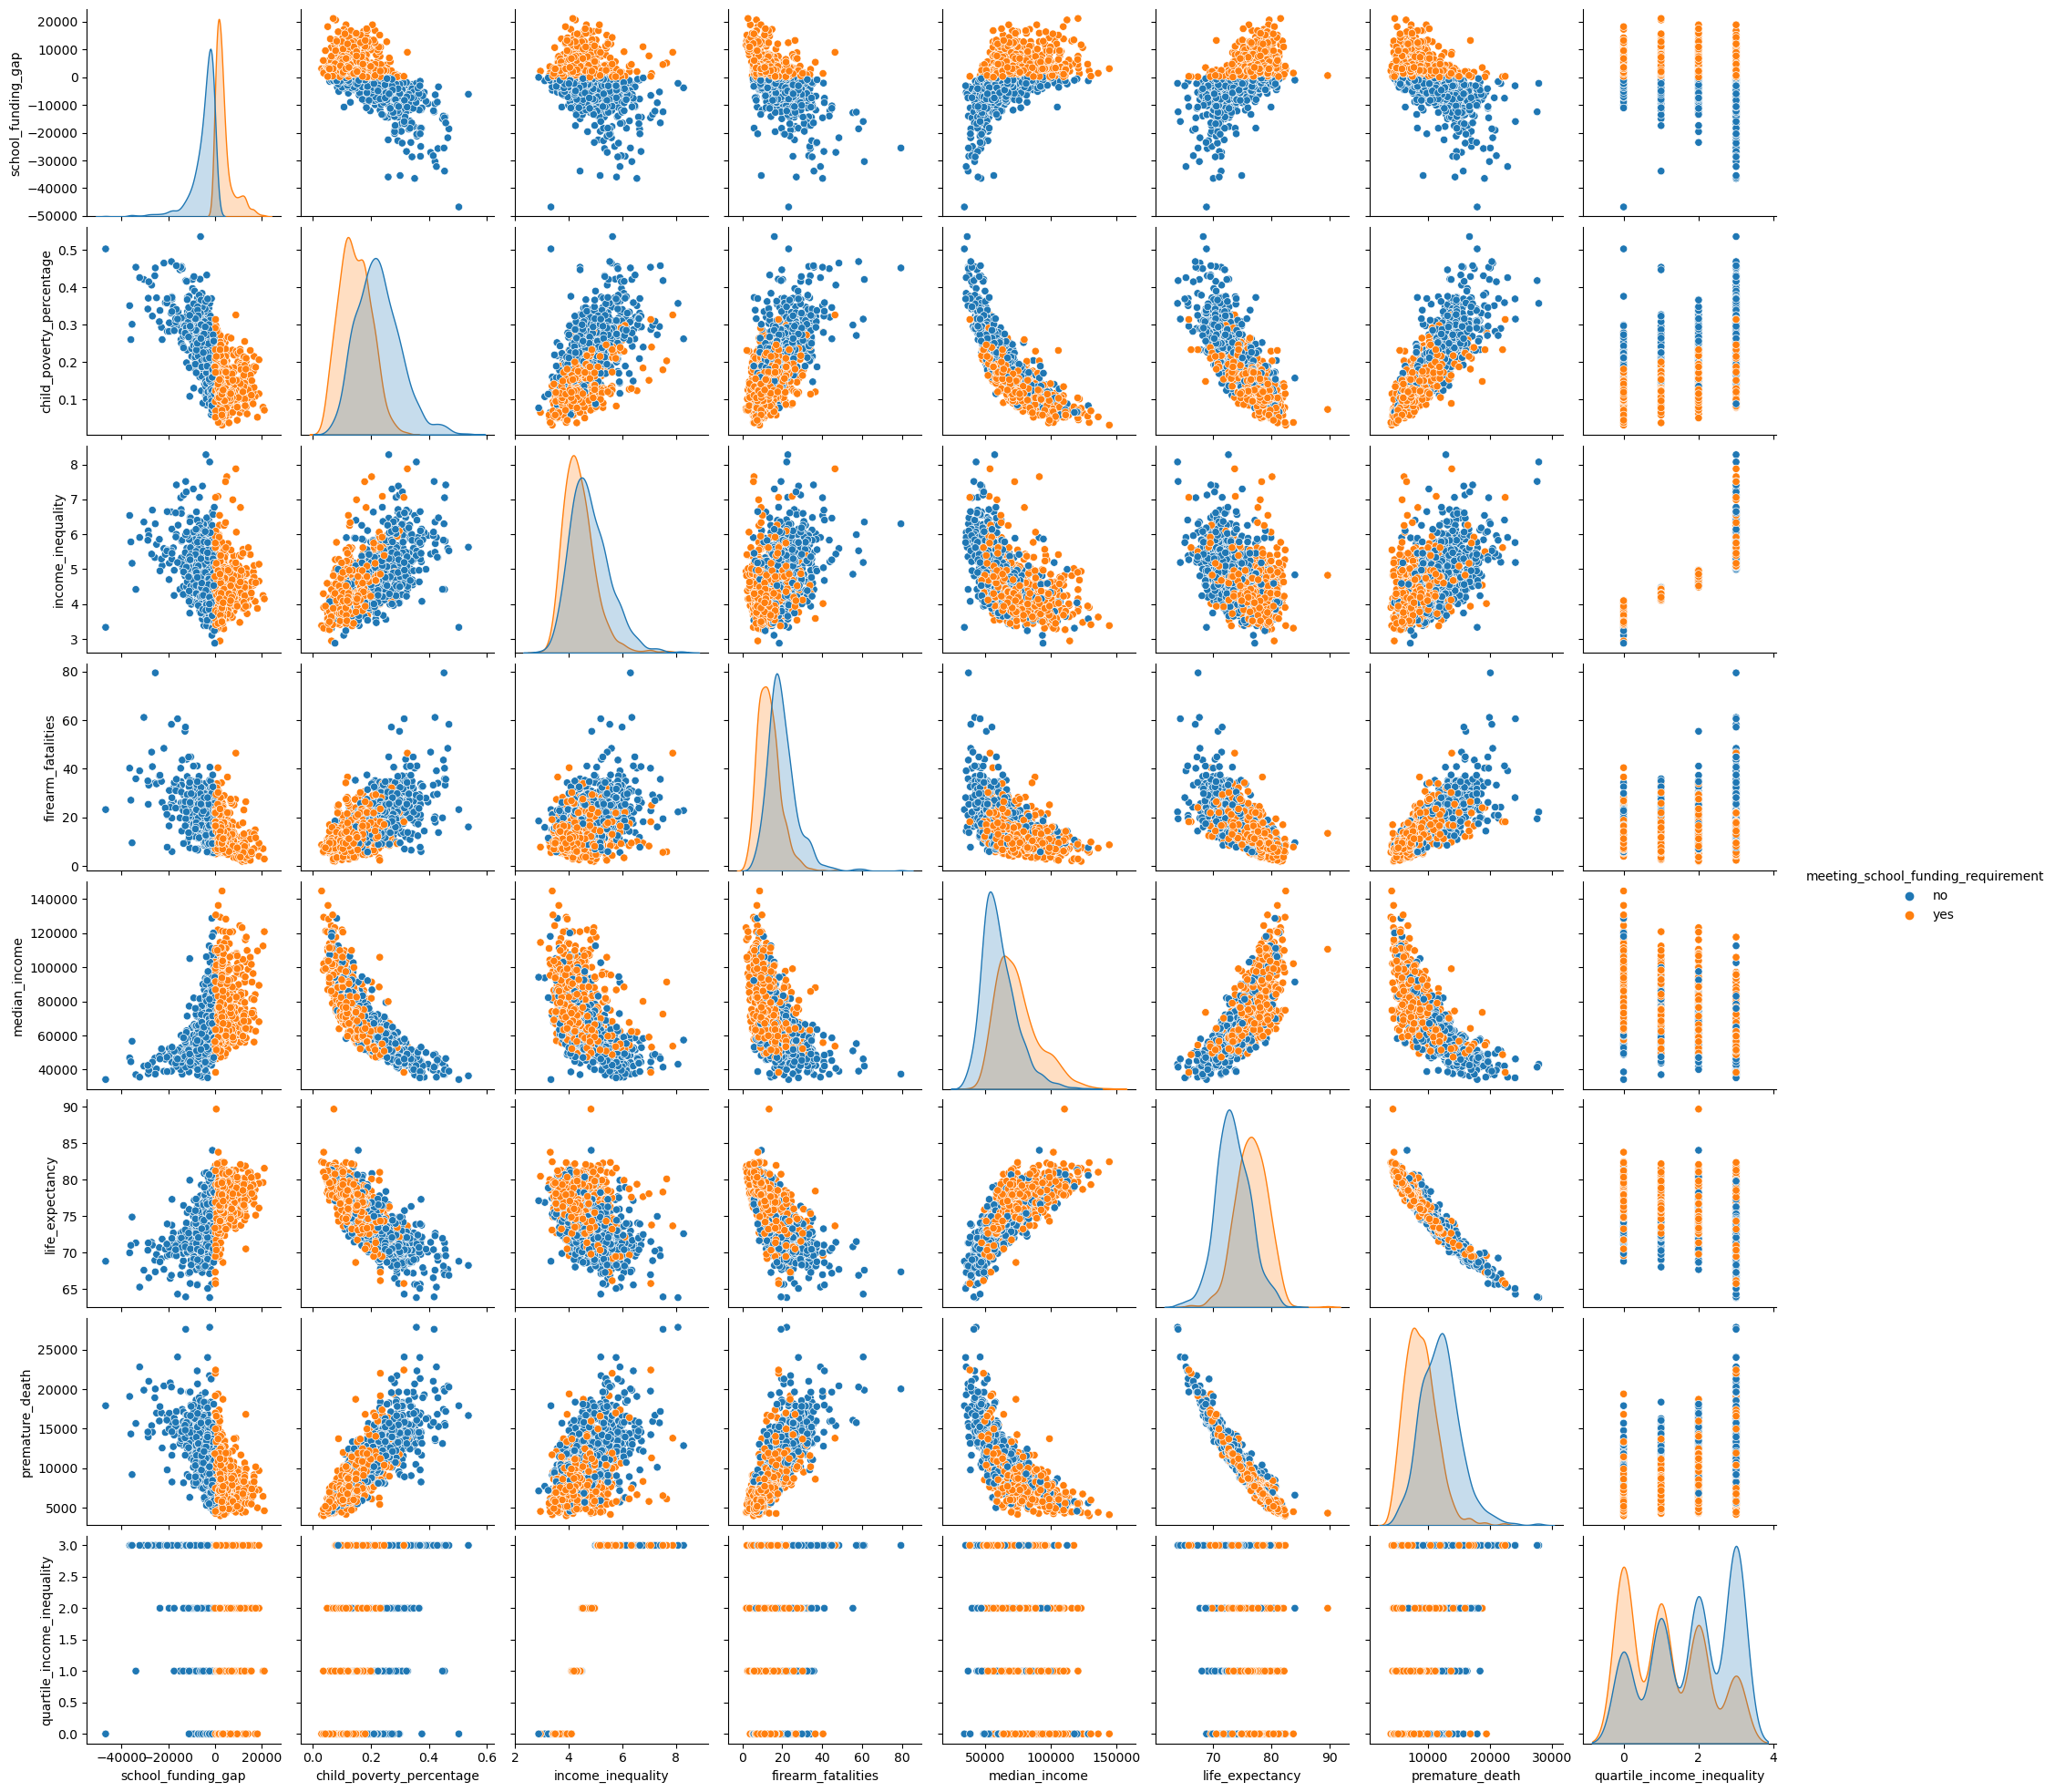

In [39]:
sns.pairplot(grouped_df, hue='meeting_school_funding_requirement')
plt.show()

### Across Quartiles of Income Inequality 

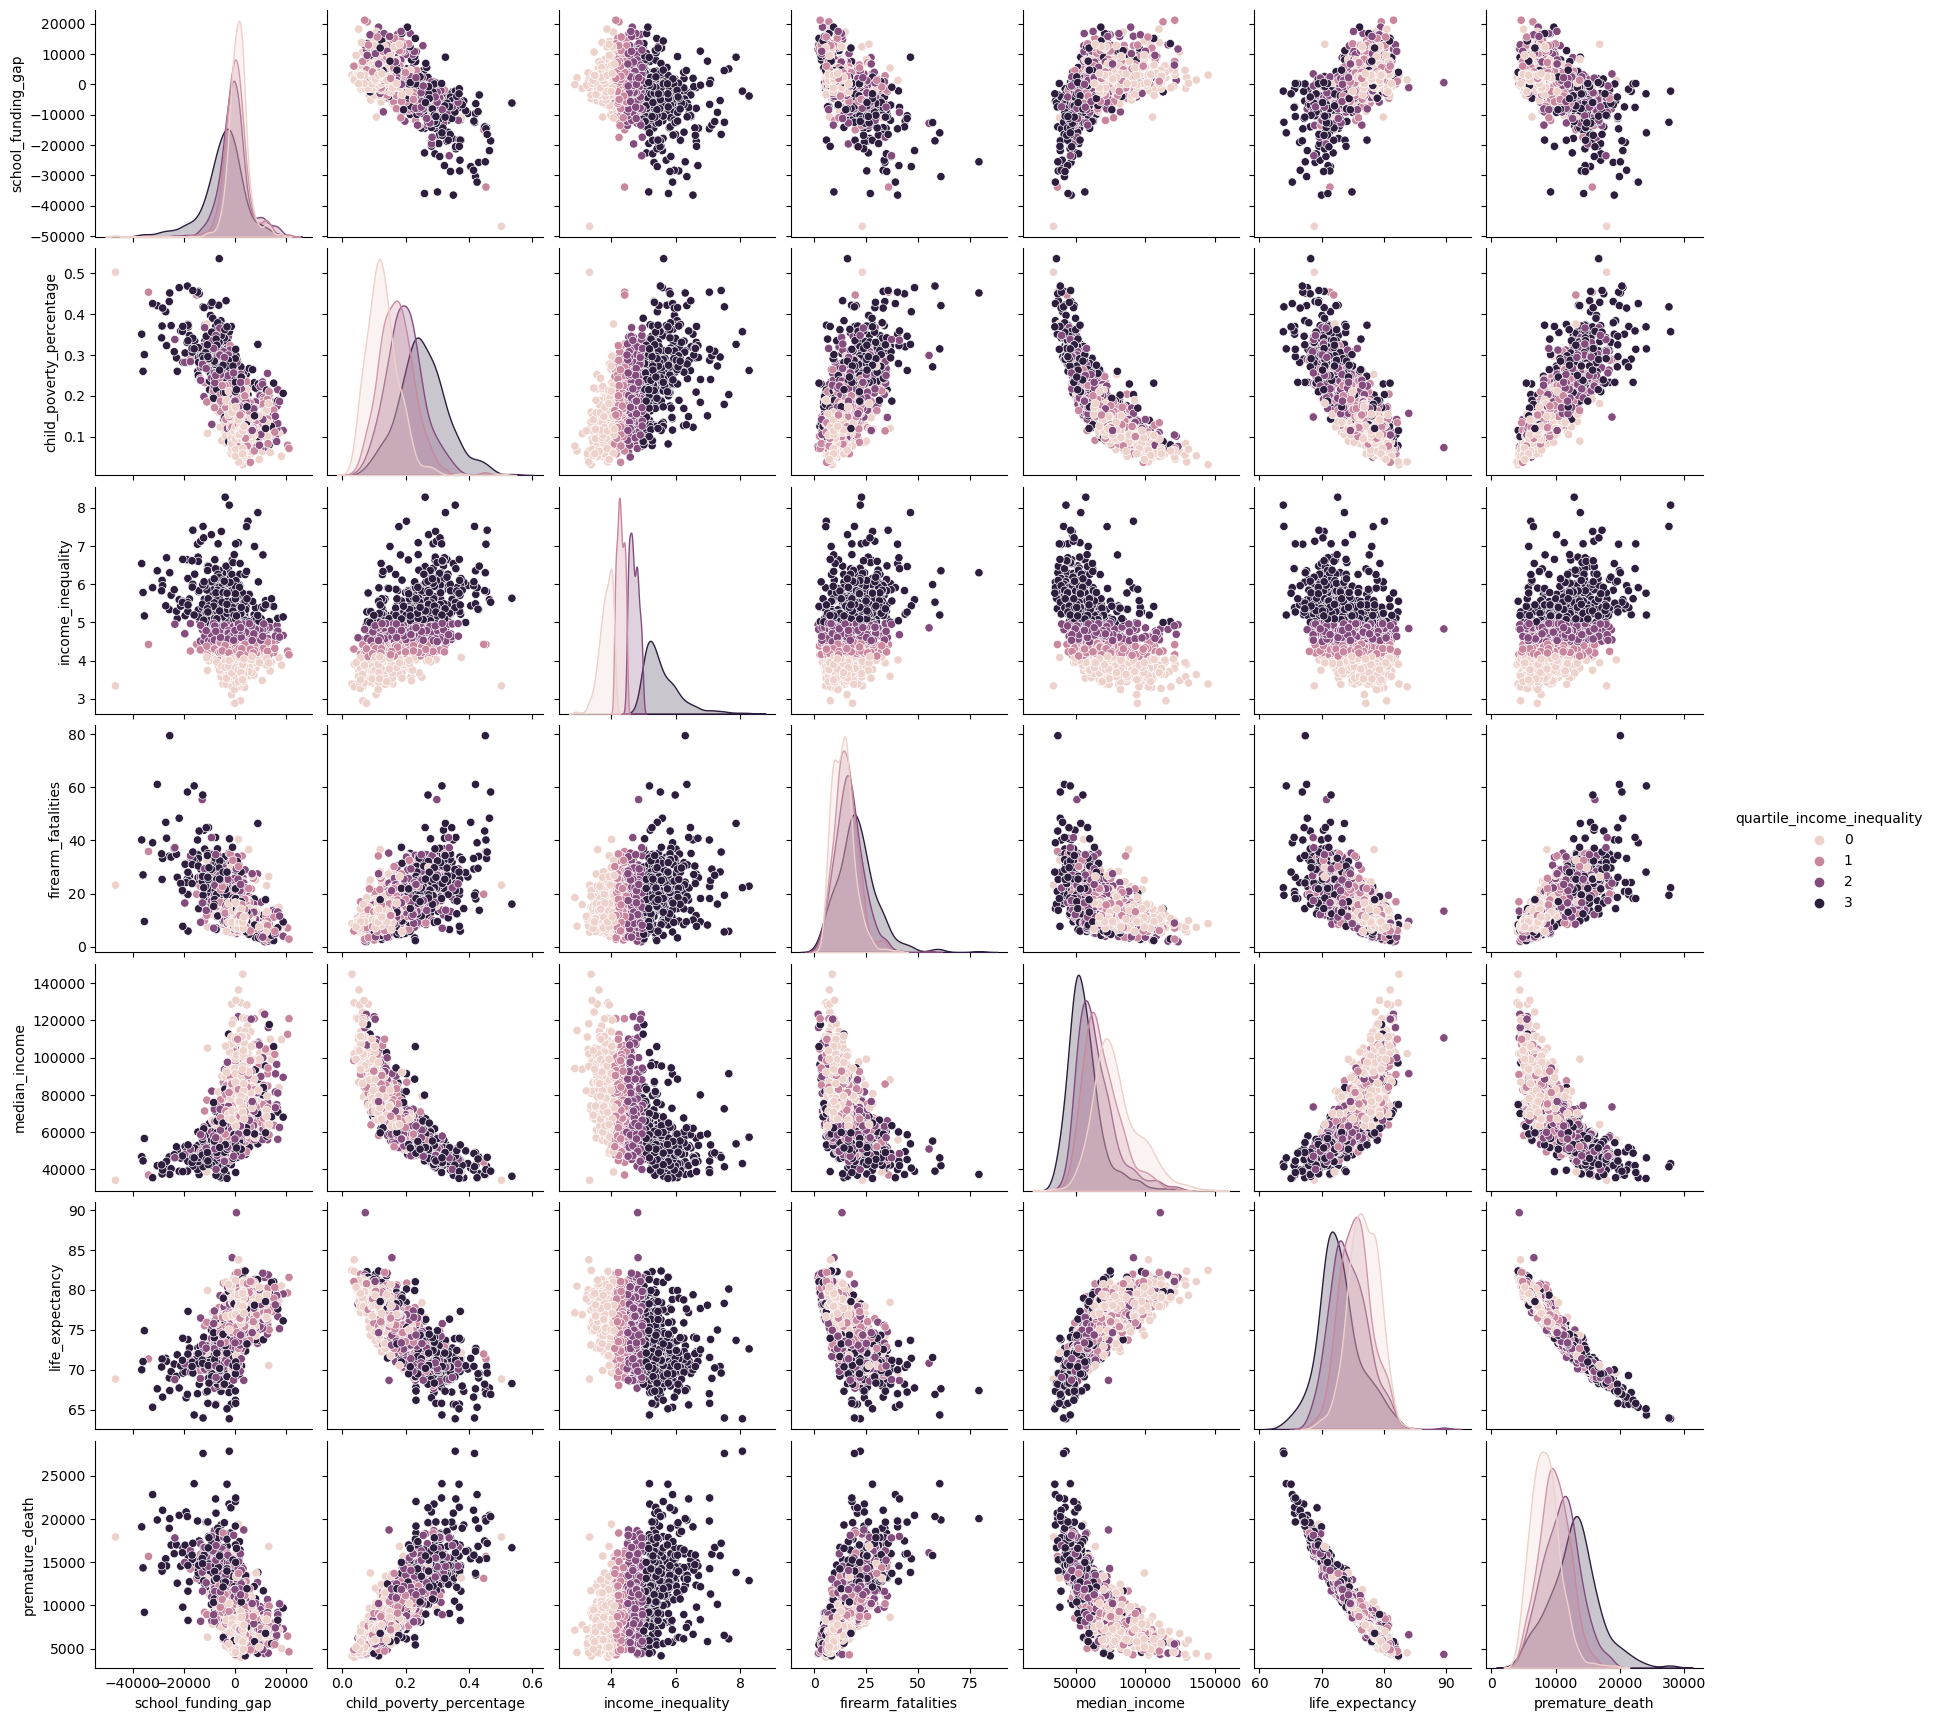

In [40]:
sns.pairplot(grouped_df, hue='quartile_income_inequality')
plt.show()

#### Closer Look at trends 

<Axes: xlabel='school_funding_gap', ylabel='premature_death'>

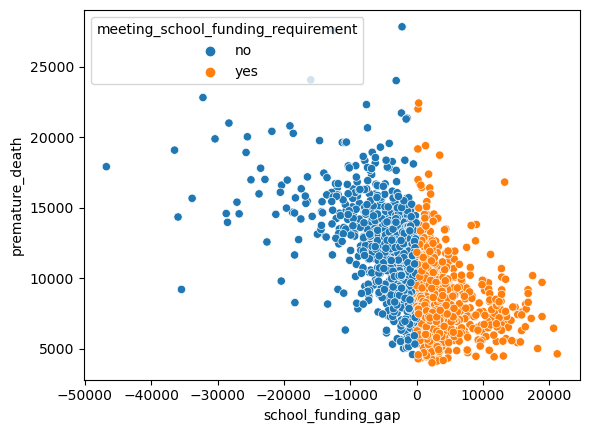

In [26]:
sns.scatterplot(data=grouped_df, x='school_funding_gap', y='premature_death', hue='meeting_school_funding_requirement')

# Chi-Squared Testing

### School Funding

### Income  Inequality

### Political Party

# Conclusion